In [3]:
%matplotlib inline
import bcolz
import glob
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.insert(0, '../utils')

from bcolz_array_iterator import BcolzArrayIterator
from keras.applications import vgg16
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model
from keras import optimizers
from PIL import Image
from tqdm import tqdm

rmean is the mean value of rgb from ImageNet

In [2]:
rmean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rmean)[:,:,:,::-1]

In [3]:
def conv_block(input_data, filter_size, kernal_size = 3, border_mode = 'same', stride = (1,1), activate = True):
    x = Convolution2D(filter_size, kernal_size, kernal_size, 
                      subsample = stride, border_mode = border_mode)(input_data)
    x = BatchNormalization(mode = 2)(x)
    return Activation('relu')(x) if activate else x

In [4]:
def res_block(input_data, filter_size = 64):
    x = conv_block(input_data, filter_size)
    x = conv_block(x, filter_size, activate = False)
    return merge([input_data, x], mode='sum')

In [5]:
def up_block(input_data, filter_size = 64):
    x = UpSampling2D()(input_data)
    x = Convolution2D(filter_size, 3, 3, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This mean_sqr function add all of the elements of the input together and divide by the number of elements. 
K.mean((x1-x2)(x1-x2), dims) will return mean of every batchs(one dim only).

In [6]:
#Example of K.mean, mean of numpy have same semantic and results as K.mean:
shape = (2,2,2,2)
cimg = np.arange(16)
cimg = cimg.reshape(shape)
print(np.mean(cimg, (1,2,3)))
#end of Example of K.mean

[  3.5  11.5]


In [7]:
def mean_sqr_b(x1, x2):
    dims = list(range(1, K.ndim(x1)))
    return K.expand_dims(K.sqrt(K.mean((x1-x2)**2, dims)), 0)

Perceptual loss is the content loss of some layers, this formula is listed at equation 1 of the paper
[Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/pdf/1603.08155.pdf)

In [8]:
loss_weight = [0.1, 0.8, 0.1]
def perceptual_loss(input_data):
    n = len(loss_weight)
    result = 0
    #input_data[i] is the output value of low/high resolution image associate with input_data[i+n]
    #input_data[i + n] is the output value of low/high resolution image associate with input_data[i]
    for i in range(n): result += mean_sqr_b(input_data[i], input_data[i+n]) * loss_weight[i]
    return result

In [9]:
dpath = '/home/ramsus/Qt/computer_vision_dataset/super_res/'
low_res_imgs = bcolz.open(dpath + 'image_net_full_72.bc')
#low_res_shp = low_res_imgs.shape[1:]
arbitrary_res_inp = Input(shape=(None,None,3))

def get_model(inp):
    x = conv_block(inp, 64, 9)
    for i in range(4): x = res_block(x)
    for i in range(2): x = up_block(x)
    x = Convolution2D(3, 9, 9, border_mode='same', activation='tanh')(x)
    return Lambda(lambda x: (x+1) * 127.5)(x)    

output = get_model(arbitrary_res_inp)

In [10]:
high_res_imgs = bcolz.open(dpath + 'image_net_full_288.bc')
high_res_inp = Input(high_res_imgs.shape[1:])
vgg16_model = vgg16.VGG16(include_top = False, input_tensor = high_res_inp)
for l in vgg16_model.layers: l.trainable = False

In [12]:
vgg_content = Model(high_res_inp, [vgg16_model.get_layer('block{}_conv2'.format(i)).output for i in [1,2,3]])
high_res_vgg = vgg_content(Lambda(preproc)(high_res_inp))
low_res_vgg = vgg_content(Lambda(preproc)(output))
super_res_model = Model([high_res_inp, arbitrary_res_inp], Lambda(perceptual_loss)(high_res_vgg + low_res_vgg))
targ = np.zeros((high_res_imgs.shape[0], 1))
adam = optimizers.Adam()
super_res_model.compile(optimizer = adam, loss = 'mae')

In [13]:
def train_network_on_batch(bs, model, save_as, niter=10, offset = 0):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(high_res_imgs, low_res_imgs, batch_size=bs)
    for i in range(offset):
        next(bc)
    for i in tqdm(range(niter)):        
        hr,lr = next(bc)
        model.train_on_batch([hr[:bs], lr[:bs]], targ)
        if(i != 0 and i%500 == 0):
            super_res_model.save_weights(save_as + '_{}'.format(i + offset)) 
            
    super_res_model.save_weights(save_as + '_{}'.format(niter + offset))

In [66]:
#train_network_on_batch(16, super_res_model, 5000)
#super_res_model.save_weights('models/super_res_80000_1_5000')

In [14]:
print(high_res_imgs.shape)
print(low_res_imgs.shape)
def copy_bcolz(from_arr, new_size):    
    result = bcolz.carray(np.empty((0, new_size, new_size, 3), 'float32'), 
                          chunklen=16, mode='w', rootdir='image_net_80000_{}.bc'.format(new_size))
    for i in range(80000):
        result.append(from_arr[i])
        
    result.flush()
        
    return result

low_res_small_imgs = bcolz.open('image_net_80000_72.bc')
high_res_small_imgs = bcolz.open('image_net_80000_288.bc')
targ = np.zeros((high_res_small_imgs.shape[0], 1))
print(high_res_small_imgs.shape)
print(low_res_small_imgs.shape)

(1261174, 288, 288, 3)
(1261174, 72, 72, 3)
(80000, 288, 288, 3)
(80000, 72, 72, 3)


In [17]:
def train_with_fit(epoch, save_as):
    super_res_model.fit([high_res_small_imgs, low_res_small_imgs], targ, 16, epoch)
    with open(save_as + ".json", "w") as json_file:
        json_file.write(super_res_model.to_json())
    super_res_model.save_weights(save_as)

In [19]:
train_with_fit(1, 'models/super_res_80000_epoch_1_0')
train_with_fit(1, 'models/super_res_80000_epoch_2_0')

In [ ]:
#from https://vzaguskin.github.io/histmatching1/
def hist_match_color(imsrc, target):
    nbr_bins=255    
    imres = imsrc.copy()
    for d in range(imsrc.shape[2]):
        imhist,bins = np.histogram(imsrc[:,:,d].flatten(),nbr_bins,normed=True)
        tinthist,bins = np.histogram(target[:,:,d].flatten(),nbr_bins,normed=True)

        cdfsrc = imhist.cumsum() #cumulative distribution function
        cdfsrc = (255 * cdfsrc / cdfsrc[-1]).astype(np.uint8) #normalize

        cdftint = tinthist.cumsum() #cumulative distribution function
        cdftint = (255 * cdftint / cdftint[-1]).astype(np.uint8) #normalize

        im2 = np.interp(imsrc[:,:,d].flatten(),bins[:-1],cdfsrc)
        im3 = np.interp(im2,cdftint, bins[:-1])

        imres[:,:,d] = im3.reshape((imsrc.shape[0],imsrc.shape[1] ))

    return imres

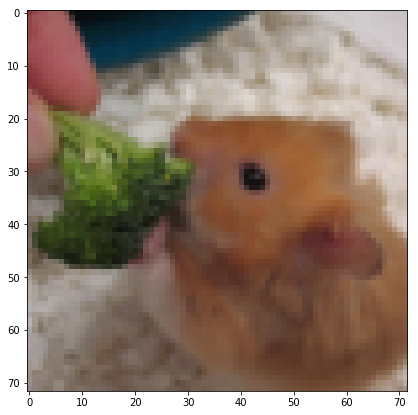

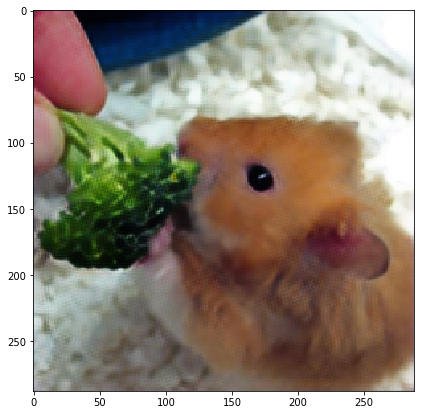

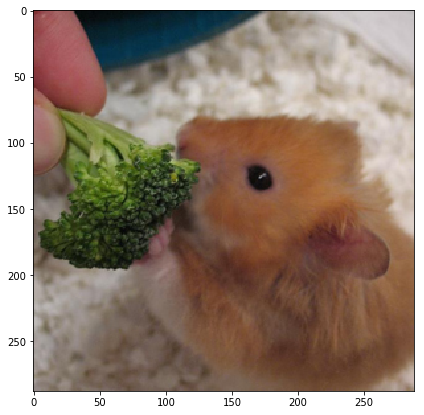

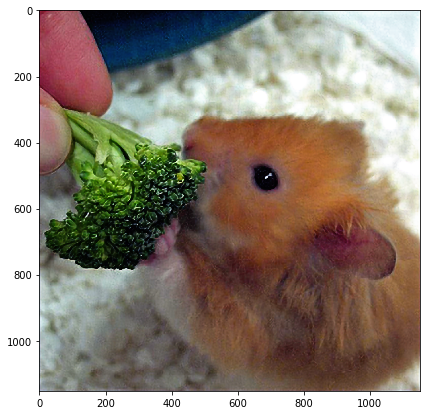

In [43]:
def upscale_imagenet_img(input_arr, index, model):
    plt.figure(figsize=(7,7))
    plt.imshow(input_arr[index].astype('uint8'))
    p = model.predict(np.expand_dims(input_arr[index],0))
    plt.figure(figsize=(7,7))
    plt.imshow(p[0].astype('uint8'))    

index = 4000
upscale_imagenet_img(low_res_small_imgs, index, high_res_model)    
upscale_imagenet_img(high_res_small_imgs, index, high_res_model)